In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#load datasets
resale_flats = pd.read_csv('ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv')
rent_flats = pd.read_csv('RentingOutofFlatsfromJan2021.csv')
# print(resale_flats.head())
# print(rent_flats.head())
# print(resale_flats.info())
# print(rent_flats.info())


Some data that are present in 1 dataset are not present in the other. Namely storey_range, floor_area_sqm, flat model, lease_commence_date, remaining_lease. 
No missing data, however, data needs to be standardized E.g. month vs rent_approval_date, 2-ROOM vs 2 ROOM.
Needs to change datatype to datetime

In [ ]:
#preprocessing

#Convert month, rent_approval_date and lease_commence_date to datetime
resale_flats['month'] = pd.to_datetime(resale_flats['month'], format='%Y-%m')
rent_flats['rent_approval_date'] = pd.to_datetime(rent_flats['rent_approval_date'], format='%Y-%m')
resale_flats['lease_commence_date'] = pd.to_datetime(resale_flats['lease_commence_date'], format='%Y')
# print(resale_flats.head())
# print(rent_flats.head())

#resale has Central Area which is not present in resale_towns (central) 
#So we will replace Central Area with Central in resale_flats
resale_flats['town'] = resale_flats['town'].str.strip() #remove leading/trailing spaces
resale_flats['town'] = resale_flats['town'].str.upper() #convert to uppercase for uniformity

rent_flats['town'] = rent_flats['town'].str.strip()
rent_flats['town'] = rent_flats['town'].str.upper()
resale_flats['town'] = resale_flats['town'].str.replace('CENTRAL AREA', 'CENTRAL')

#replace ' ROOM' within resale_flats to '-ROOM'
resale_flats['flat_type'] = resale_flats['flat_type'].str.replace(' ROOM', '-ROOM')

#Using towns as common key for clustering
resale_towns = resale_flats['town'].unique()
rent_towns = rent_flats['town'].unique()

# print(resale_towns)
# print(rent_towns)

#resale_towns does not have TENGAH but rent_towns has TENGAH
#we will not use tengah in our analysis as a result (total 25 towns)
common_towns = set(resale_towns).intersection(set(rent_towns))
flat_types = set(resale_flats['flat_type'].unique()).intersection(set(rent_flats['flat_type'].unique()))
# print(flat_types)
# print(common_towns)
# print(len(common_towns))
#drop rows with towns not in common_towns, these will be used as a direct comparison
resale_flats_clean = resale_flats[resale_flats['town'].isin(common_towns)] 
rent_flats_clean = rent_flats[rent_flats['town'].isin(common_towns)]



{'5-ROOM', '2-ROOM', '3-ROOM', '1-ROOM', 'EXECUTIVE', '4-ROOM'}
{'ANG MO KIO', 'BISHAN', 'MARINE PARADE', 'BUKIT BATOK', 'QUEENSTOWN', 'CLEMENTI', 'TAMPINES', 'CHOA CHU KANG', 'CENTRAL', 'BEDOK', 'WOODLANDS', 'PASIR RIS', 'JURONG EAST', 'SEMBAWANG', 'PUNGGOL', 'TOA PAYOH', 'SERANGOON', 'KALLANG/WHAMPOA', 'SENGKANG', 'GEYLANG', 'BUKIT PANJANG', 'HOUGANG', 'JURONG WEST', 'BUKIT MERAH', 'YISHUN', 'BUKIT TIMAH'}
26


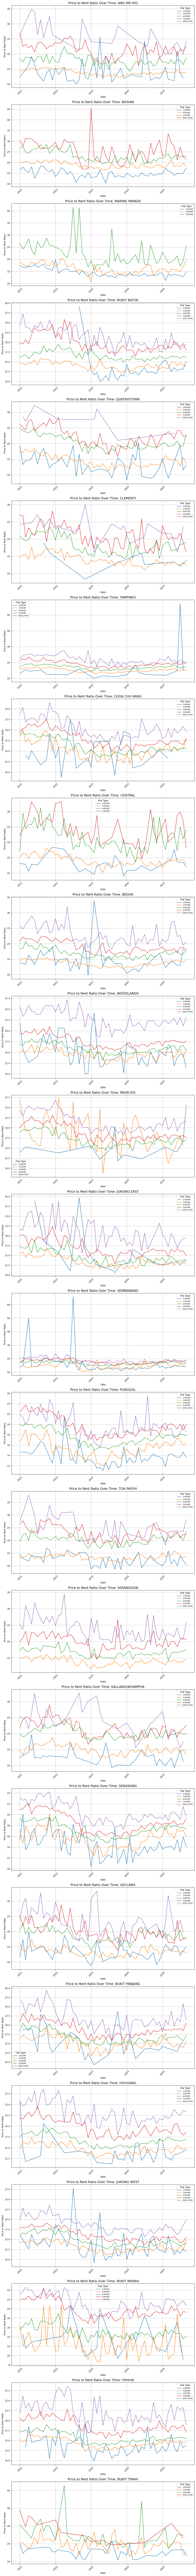

In [19]:
#Find average resale price and rent price per town for each year, grouped by flat_type
average_resale_prices = resale_flats_clean.groupby([ 'town','flat_type', 'month'])['resale_price'].mean().reset_index()
average_rent_prices = rent_flats_clean.groupby(['town','flat_type', 'rent_approval_date'])['monthly_rent'].mean().reset_index()

#Merge the two datasets on town, flat_type and month/rent_approval_date
price_rent_ratio = pd.merge(average_resale_prices, average_rent_prices, left_on=[ 'town','flat_type', 'month'], right_on=[ 'town','flat_type', 'rent_approval_date'], how='inner')
#Calculate price to rent ratio
price_rent_ratio['price_rent_ratio'] = price_rent_ratio['resale_price'] / (price_rent_ratio['monthly_rent'] * 12)

#Visualize the price to rent ratio for each flat_type in each town over time

# Create a figure and a grid of subplots (one per town + one additional plot for all towns)
fig, axes = plt.subplots(len(common_towns) , 1, figsize=(12, 6 * (len(common_towns))))

# Loop through each town and plot its data in the respective subplot
for i, town in enumerate(common_towns):
    town_data = price_rent_ratio[price_rent_ratio['town'] == town]
    
    ax1 = axes[i]
    
    # Use seaborn lineplot with hue to automatically differentiate flat_types
    sns.lineplot(data=town_data, x='month', y='price_rent_ratio', 
                 ax=ax1, hue='flat_type', palette="tab10")
    
    ax1.set_title(f'Price to Rent Ratio Over Time: {town}', fontsize=14)
    ax1.set_xlabel('Date', fontsize=10)
    ax1.set_ylabel('Price to Rent Ratio', fontsize=10)
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend(title='Flat Type', fontsize=8)
    
    # Add grid for better visualization
    ax1.grid(True)


# Adjust layout so everything fits
plt.tight_layout()

# Show the plot
plt.show()


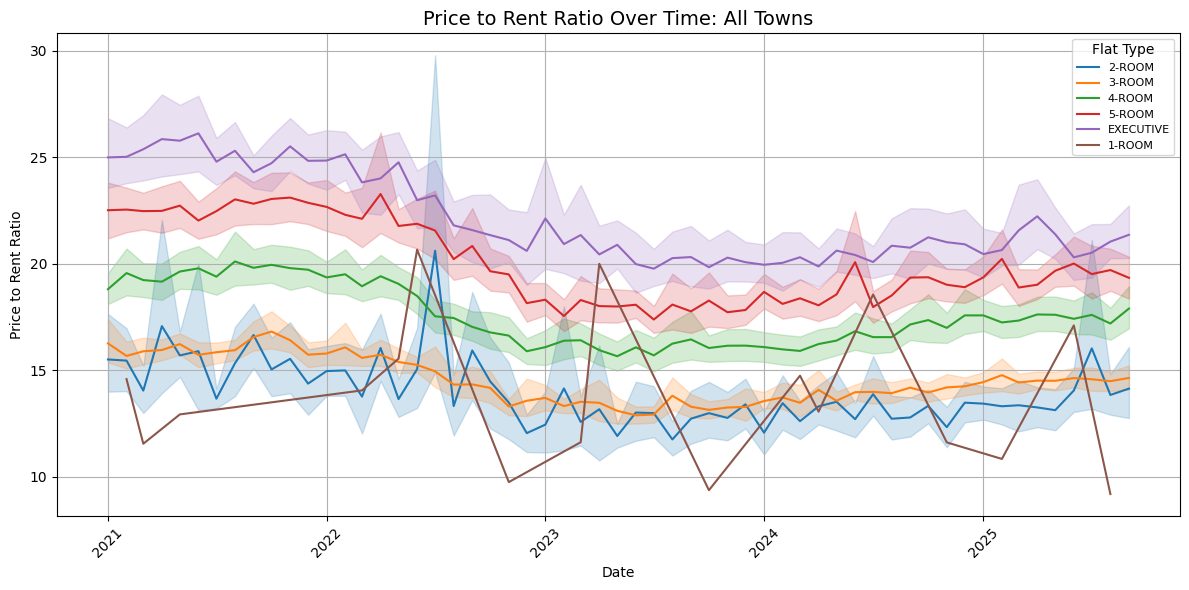

In [21]:
#Plot for all towns combined
fig, ax_all = plt.subplots(figsize=(12, 6))
sns.lineplot(data=price_rent_ratio, x='month', y='price_rent_ratio', 
             ax=ax_all, hue='flat_type', palette="tab10")
ax_all.set_title('Price to Rent Ratio Over Time: All Towns', fontsize=14)
ax_all.set_xlabel('Date', fontsize=10)
ax_all.set_ylabel('Price to Rent Ratio', fontsize=10)
ax_all.tick_params(axis='x', rotation=45)
ax_all.legend(title='Flat Type', fontsize=8)
ax_all.grid(True)
# Show the plot
plt.tight_layout()
plt.show()


Based on the visualizations, we can see that the bigger flats have a higher "Price to Rent Ratio" across all towns. 
Only Bukit Merah has 1-Room flats. 
Smaller flats can have a bigger variance in Price/Rent, likely due to outliers. Possibly low number of transactions, hence more susceptible to outlier


In [22]:
#Logistic Regression to predict price of flats based on features
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
# Prepare the data

